# CMM560 Topic 9.1 Lab: Transfer Learning


* Credit: Prof Eyad Elyan's [GitHub tutorial](https://github.com/heyad/Teaching/blob/master/CV/Lab05U.ipynb)



## 1. Loading Packages

In [1]:
# import the required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from matplotlib.image import imread
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, AveragePooling2D,Flatten, Dense, Conv2D,MaxPool2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

## 2. Load and Explore Data

Original dataset obtained from [here](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).

* You can uncomment the code below if the file is a zip file

In [2]:
## Run this cell to import the chest x-ray dataset from my dropbox to Colab
!wget -O data.zip https://www.dropbox.com/scl/fi/x9wbnxox44rey6xym4un7/data.zip?rlkey=uo2pos87olc6zgkdhp5dcverb&raw=1
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

You will notice that you have three subfolders inside `chest_xray`: train, test, and validation. These will be used for building and evaluating your model's performance. Within each of these folders, you have two subfolders: **NORMAL** and **PNEUMONIA**.

In [3]:
# path for train/ test and validate folders
train_folder_path = '/content/chest_xray/train/'
test_folder_path = '/content/chest_xray/test/'
val_folder_path = '/content/chest_xray/val/'

We can get the labels "automatically"

In [4]:
labels = os.listdir(train_folder_path)
labels

['NORMAL', 'PNEUMONIA']

The path's variables below point to the negative and positive instances of the training and testing sets (folders). We will use these to check the class distribution in our dataset. In other words, how many positive and negative instances are available. Recall, a hugely imbalanced dataset can lead to biased results.

In [5]:
train_n_path = train_folder_path+'/NORMAL/'
train_p_path = train_folder_path+'/PNEUMONIA/'

test_n_path = test_folder_path+'/NORMAL/'
test_p_path = test_folder_path+'/PNEUMONIA/'

print(f'Number of normal images: {len(os.listdir(train_n_path))}') #length of normal training images
print(f'Number of postive images: {len(os.listdir(train_p_path))}') #length of pneumonia training images
print(f'Total training images: {len(os.listdir(train_n_path)) + len(os.listdir(train_p_path))}')

Number of normal images: 1341
Number of postive images: 3875
Total training images: 5216


You can also check the number of images in the testing director

In [6]:
print(f'Number of normal images: {len(os.listdir(test_n_path))}')
print(f'Number of positive images: {len(os.listdir(test_p_path))}')
print(f'Total training images: {len(os.listdir(test_n_path)) + len(os.listdir(test_p_path))}')

Number of normal images: 234
Number of positive images: 390
Total training images: 624


Now we create a function to load data to Python

In [7]:
## Load data from files into Python variables
img_size = 112
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.asarray(data, dtype="object")

Now, we load the training set, but splitting it into train and validation. We could use the `val` folder, but it is quite small!

In [8]:
train = get_data(train_folder_path) # The function takes some time...
temp = np.random.permutation(train) # Shuffle the data
train_size = 0.8 # Sets the split ratio
train, val = temp[:(int(train_size*len(temp)))], temp[int(train_size*len(temp)):] # Assigns 80% to training array and 20% to validation set

Now let's get the testing data

In [9]:
# Load testing datasets
test = get_data(test_folder_path)

Check sizes to ensure consistency

In [10]:
print(f'The shape of the training set is {train.shape}')
print(f'The shape of the test set is {test.shape}')
print(f'The shape of the val set is {val.shape}')

The shape of the training set is (4172, 2)
The shape of the test set is (624, 2)
The shape of the val set is (1044, 2)


Let' s show the class distributions (0 denotes a normal image, while 1 denotes an image depicting pneumonia)

<Axes: xlabel='count'>

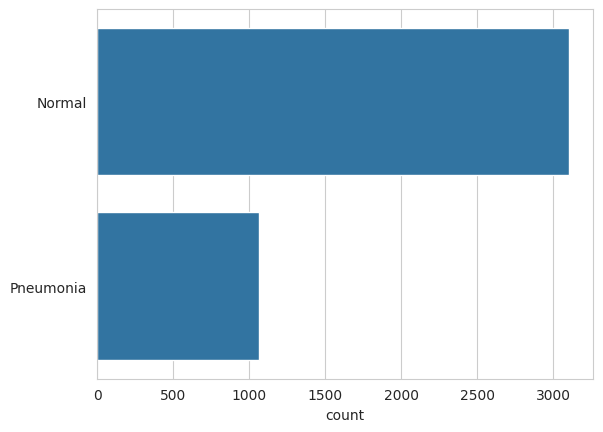

In [11]:
# for training set
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('whitegrid')
sns.countplot(l)

<Axes: xlabel='count'>

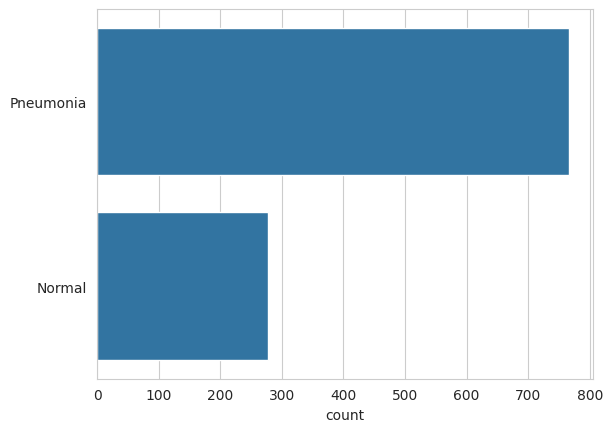

In [12]:
# for validation set
l = []
for i in val:
  if(i[1] == 0):
     l.append("Normal")
  else:
    l.append("Pneumonia")
sns.set_style('whitegrid')
sns.countplot(l)

<Axes: xlabel='count'>

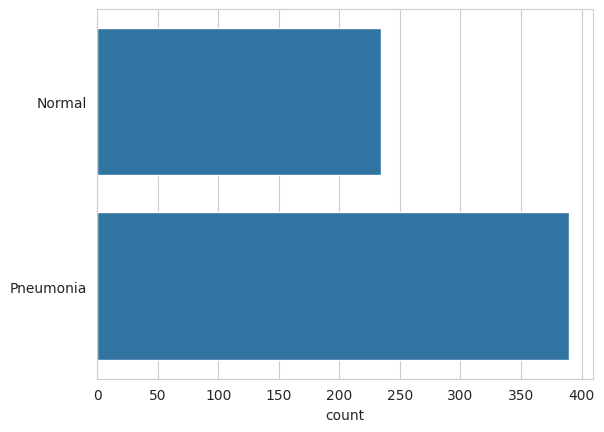

In [13]:
# for testing set
l = []
for i in test:
  if(i[1] == 0):
     l.append("Normal")
  else:
    l.append("Pneumonia")
sns.set_style('whitegrid')
sns.countplot(l)

Below is a function to show arbitray number of normal or pneumonia images **FROM THE ORIGINAL FILES (NOT THE PYTHON VARIABLES)** subject to some arguments passed.

In [14]:
def show_sample_images (number, normal=True):
    plt.figure(figsize=(12,12))
    if normal == True:
        for n in range(number):
            normal_img = os.listdir(train_n_path)[n]
            normal_img_address = train_n_path+normal_img
            normal_load = Image.open(normal_img_address)
            ax = plt.subplot(int(number/2),int(number/2),n+1)
            plt.imshow(normal_load, cmap ='gray')
            plt.title("NORMAL")
    else:
        for n in range(number):
            pneumonia_img =  os.listdir(train_p_path)[n]
            pneumonia_img_address = train_p_path+pneumonia_img
            pneumonia_load = Image.open(pneumonia_img_address)
            #cast nrows to integer
            ax = plt.subplot(int(number/2),int(number/2),n+1)
            plt.imshow(pneumonia_load, cmap ='gray')
            plt.title("PNEUMONIA")

    plt.axis("off")

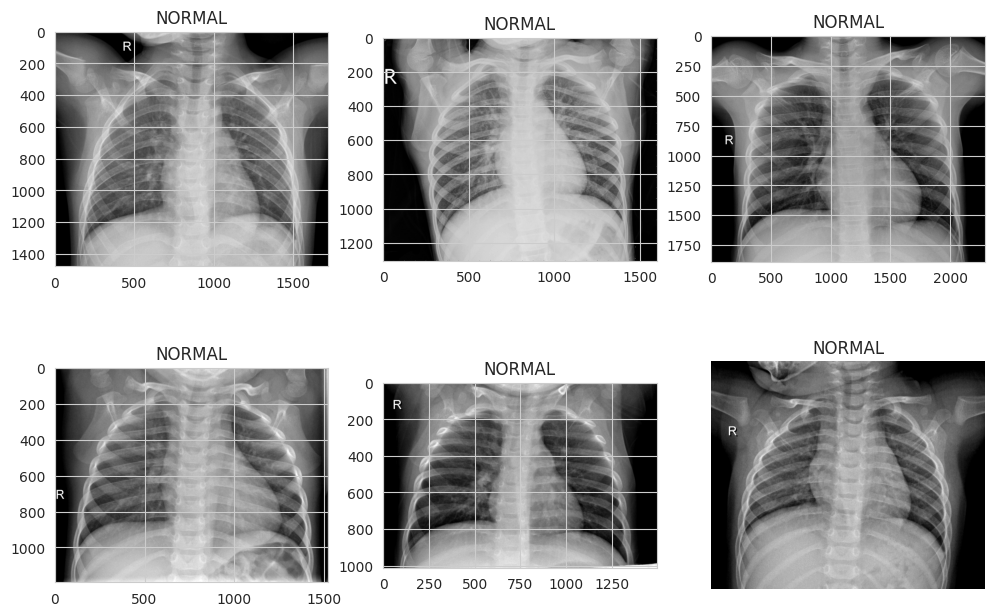

In [15]:
# Show normal images
numberImg= 6
show_sample_images(numberImg)

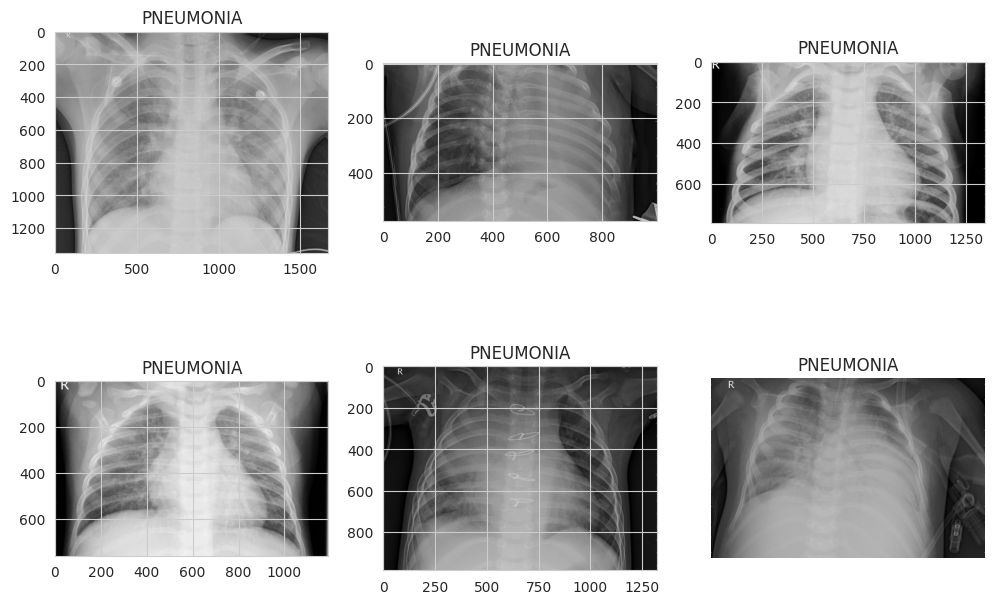

In [16]:
# show pneumonia images
show_sample_images(6,False)

Let's apply histogram equalization to improve images contrast for better visualisation (more about this technique can be found [here](https://homepages.inf.ed.ac.uk/rbf/HIPR2/histeq.htm) and [here](https://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_hist). As you can see below, this gives a better visualisation of the images:

In [17]:
from skimage import exposure

In [18]:
def equlize_hist_ (image):
  _image = np.asarray(image)
  image_eq = exposure.equalize_hist(_image)
  return image_eq


In [19]:
def expose_imgae(Normal=True):
    if Normal==True:
        # Choose normal random image: generate random number between 1 and  the number of normal images in the training set
        random_img_ind= np.random.randint(0,len(os.listdir(train_n_path)))
        # image file name
        img_expose_name = os.listdir(train_n_path)[random_img_ind]

        # path to the image
        img_expose_address = train_n_path+img_expose_name

        # load mage
        img_expose = Image.open(img_expose_address)
        img = np.asarray(img_expose)
        image_eq = equlize_hist_(img)
        figure1 = plt.figure(figsize= (16,16))
        img_1 = figure1.add_subplot(1,2,1)
        img_plot = plt.imshow(img, cmap = 'gray')
        img_1.set_title('Normal')
        plt.axis("off")

        img2 = figure1.add_subplot(1, 2, 2)
        img_plot = plt.imshow(image_eq, cmap = 'gray')
        img2.set_title('Normal after HE')
        plt.axis("off")
    else:
        # Choose normal random image: generate random number between 1 and  the number of normal images in the training set
        random_img_ind= np.random.randint(0,len(os.listdir(train_p_path)))
        # image file name
        img_expose_name = os.listdir(train_p_path)[random_img_ind]

        # path to the image
        img_expose_address = train_p_path+img_expose_name

        # load mage
        img_expose = Image.open(img_expose_address)
        img = np.asarray(img_expose)
        image_eq = equlize_hist_(img)
        figure1 = plt.figure(figsize= (16,16))
        img_1 = figure1.add_subplot(1,2,1)
        img_plot = plt.imshow(img, cmap = 'gray')
        img_1.set_title('Pneumonia')
        plt.axis("off")

        img2 = figure1.add_subplot(1, 2, 2)
        img_plot = plt.imshow(image_eq, cmap = 'gray')
        img2.set_title('Pneumonia after HE')
        plt.axis("off")



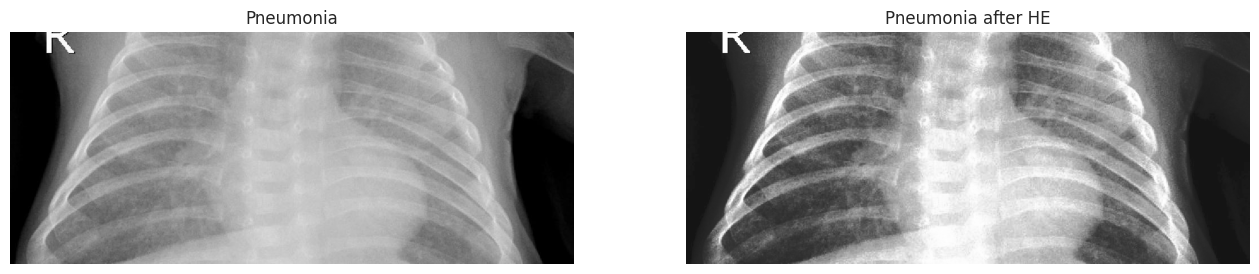

In [20]:
# expose_image() will show random normal image
expose_imgae(False)

## 3. Build a Vanilla CNN Model

First step, we want to arrange the data in different constructs (x_train, y_train, x_test, y_test, x_val,y_val), etc...):

In [21]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [22]:
print(f'Number of images in the training set is {len(x_train)}')

Number of images in the training set is 4172


In [23]:
# Normalise the data , 255.0 because we want to retain float values (work better, more precise)
x_train = np.array(x_train) / 255.0
x_val = np.array(x_val) / 255.0
x_test = np.array(x_test) / 255.0

Resize the arrays for deep learning

In [24]:
# resize data for deep learning (img_size above is set to 244 by 244)
x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

### Image Data Generator


In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

datagen = ImageDataGenerator(

      featurewise_center=False,
      samplewise_center=False,
      featurewise_std_normalization=False,
      samplewise_std_normalization=False,
      zca_whitening=False,
      rotation_range = 30,
      zoom_range = 0.2,

      width_shift_range = 0.1,
      height_shift_range = 0.1,
      horizontal_flip = True,
      vertical_flip=False)

datagen.fit(x_train)

### CNN Model

The code below defines a CNN model. Notice, that this is almost similar to most of the architecture we discussed in the lectures (e.g. Conv layers, followed by pooling and drop out, repeated a few times). A couploe of notes about the code below:

1. Notice the **BatchNormalization** layer that is added to the model. This is often used to speed up the training process and make it more stable. It does so by normalizing the inputs from hidden layers, you can find more details about batch normalization at this [https://towardsdatascience.com/batch-normalization-in-3-levels-of-understanding-14c2da90a338](https://towardsdatascience.com/batch-normalization-in-3-levels-of-understanding-14c2da90a338)

2. The **Droput** layer: is used to prevent overfitting of the model. It does this by setting some input units to 0 during the training process (e.g. switching off some neurons in the network)

In [26]:
# Model setup
model = Sequential()
model.add(Conv2D(32, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(64, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(64, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(128, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(256, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(
              optimizer = 'rmsprop', loss = 'binary_crossentropy',
              metrics = ['accuracy']
              )


In [27]:
# model summary (see the number of trainable parameters)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 112, 112, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 56, 56, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 56, 56, 64)        2

### Running the model

One thing we need to add before running the model is to account for the class imbalance in our dataset. Image Data Generator has a parameter for setting class weight, that can help address the imbalance story. More about this can be found [here](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#calculate_class_weights](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#calculate_class_weights).

In summary, we want to give heavier weight for minority class instances. To compute the class weight for each of our classes (normal, and pneumonia), we follow this formula:


$$weight_0 = \frac{1}{Neg} \times \frac{total}{2}$$
$$weight_1 = \frac{1}{Pos} \times \frac{total}{2}$$

In [28]:
total = len(os.listdir(train_n_path)) + len(os.listdir(train_p_path))
neg = len(os.listdir(train_n_path))
pos = len(os.listdir(train_p_path))

weight_for_0 = 1 /neg * (total/2.0)
weight_for_1 = 1/pos *(total/2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 1.9448173005219984, 1: 0.6730322580645162}

We set up some learning rate restrictions and run the model

In [29]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, verbose = 1, factor = 0.3, min_lr = 0.000001)

In [30]:
# Start training the model
batch_size = 16
n_epochs = 25
history = model.fit(datagen.flow(x_train, y_train, batch_size = batch_size),
                    epochs = n_epochs, validation_data = datagen.flow(x_val, y_val),
                    callbacks = [learning_rate_reduction], class_weight = class_weight)

Epoch 1/25
261/261 [==============================] - 28s 81ms/step - loss: 0.5719 - accuracy: 0.7972 - val_loss: 56.8277 - val_accuracy: 0.7347 - lr: 0.0010
Epoch 2/25
261/261 [==============================] - 20s 78ms/step - loss: 0.4050 - accuracy: 0.8581 - val_loss: 7.2900 - val_accuracy: 0.7347 - lr: 0.0010
Epoch 3/25
261/261 [==============================] - 19s 73ms/step - loss: 0.3181 - accuracy: 0.8943 - val_loss: 0.7107 - val_accuracy: 0.7845 - lr: 0.0010
Epoch 4/25
261/261 [==============================] - 20s 78ms/step - loss: 0.2991 - accuracy: 0.8955 - val_loss: 0.8907 - val_accuracy: 0.8132 - lr: 0.0010
Epoch 5/25
261/261 [==============================] - 19s 73ms/step - loss: 0.2568 - accuracy: 0.9104 - val_loss: 0.4919 - val_accuracy: 0.7960 - lr: 0.0010
Epoch 6/25
261/261 [==============================] - 19s 72ms/step - loss: 0.2330 - accuracy: 0.9211 - val_loss: 0.2889 - val_accuracy: 0.8985 - lr: 0.0010
Epoch 7/25
261/261 [==============================] - 20s

### Analysing the Results

<Axes: >

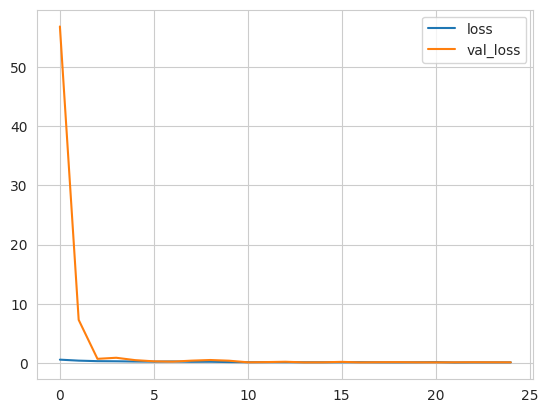

In [31]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

<Axes: >

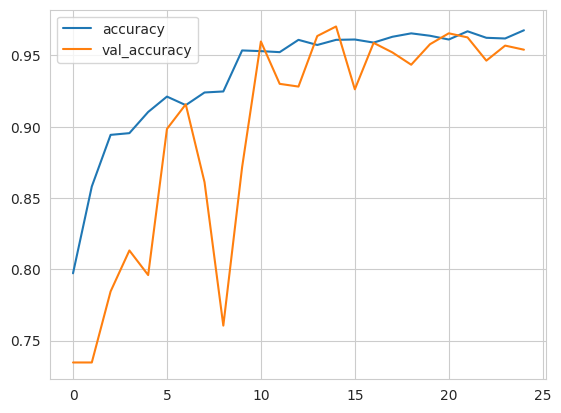

In [32]:
losses[['accuracy','val_accuracy']].plot()

Check the testing accuracy/loss

In [33]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 10ms/step - loss: 0.2867 - accuracy: 0.8990
Loss of the model is -  0.2866748869419098
20/20 [==============================] - 0s 8ms/step - loss: 0.2867 - accuracy: 0.8990
Accuracy of the model is -  89.90384340286255 %


Save the model and make some predictions:

In [34]:
from tensorflow.keras.models import load_model
#model.save('CNN_PNEUMONIA.h5') #
#cnn_model = load_model("./CNN_PNEUMONIA.h5")
predictions=model.predict(x_test)
pred_labels= np.where(predictions>0.5, 1, 0)


20/20 [==============================] - 0s 7ms/step


In [35]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, pred_labels, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.84      0.90      0.87       234
   Normal (Class 1)       0.94      0.90      0.92       390

           accuracy                           0.90       624
          macro avg       0.89      0.90      0.89       624
       weighted avg       0.90      0.90      0.90       624



Plot the confusion matrix in a colourful way!

<Axes: >

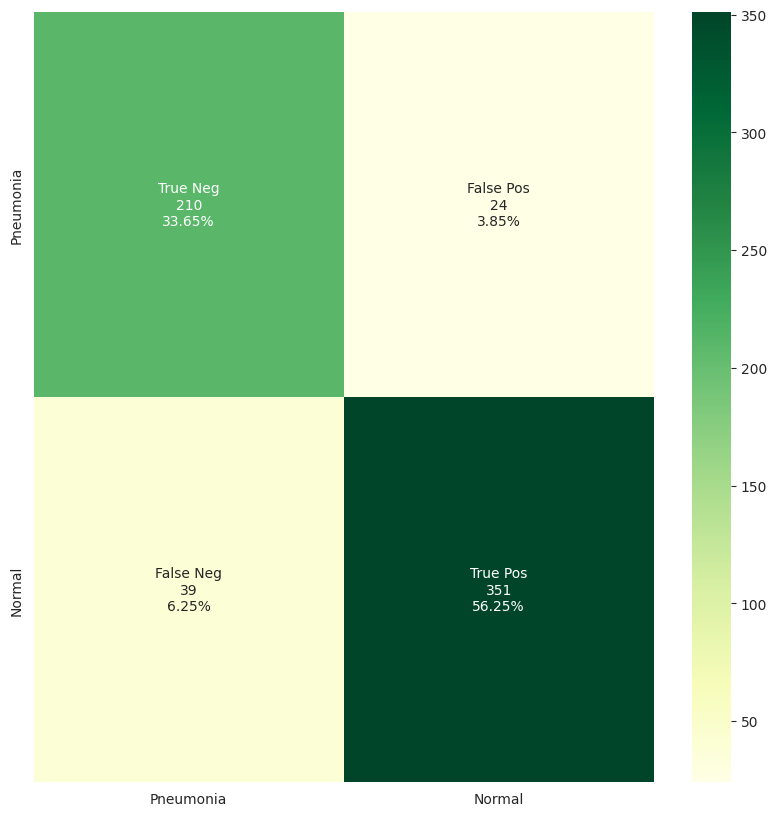

In [36]:
cf_matrix = confusion_matrix(y_test, pred_labels)
plt.figure(figsize = (10,10))
classes = ['Pneumonia','Normal']
labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn" ,
            xticklabels = classes,yticklabels = classes
           )

In [37]:
# store actual class labels and predicted ones in a dataframe
results = pd.DataFrame({'Actual':y_test,'Predicted':pred_labels.flatten()})
incorrect_df = results[results.Actual!=results.Predicted]
incorrect_df.head()

,Actual,Predicted
1,0,1
15,0,1
21,0,1
24,0,1
68,0,1


In [38]:
# manual calculation of of results
print(f'Accuracy is {round((results.shape[0]-incorrect_df.shape[0])/results.shape[0],2)*100} %')

Accuracy is 90.0 %


## 4. Transfer Learning


### Pre-trained models

Here, we will use a pre-trained model to perform classificatin (Transfer Learning). Various models such as VGG16, XCeption, etc... can be used. In this example, we will use  ResNet152V2 available on the Keras Package. More about this model can be found [here](https://keras.io/api/applications/resnet/#resnet152v2-function).

Also notice that these models have been trained using large number of images. More details about pre-trained models with keras and transfer learning can be found [here](https://keras.io/guides/transfer_learning/)

In [39]:
from keras.applications.vgg16 import VGG16 #(if you want to use VG16)
from keras.applications.inception_v3 import InceptionV3

In [40]:
# Notice 1st time this is being run, it will download the weights for the ResNet model
tf.keras.backend.clear_session()
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(img_size, img_size, 3),
    include_top=False)
# freeze the layers
base_model.trainable = False

234545216/234545216 [==============================] - 12s 0us/step


In [41]:
def get_pretrained():

    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(img_size,img_size, 3))

    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)

    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[inputs], outputs=output)

    return model

In [42]:
model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 4, 4, 2048)        58331648  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [43]:
history_tl = model_pretrained.fit(datagen.flow(x_train,y_train, batch_size = batch_size) ,
                    epochs = n_epochs , validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction],
                    steps_per_epoch = x_train.shape[0]/batch_size,
                    class_weight = class_weight
                   )

Epoch 1/25
261/260 [==============================] - ETA: 0s - loss: 0.4009 - binary_accuracy: 0.8250

260/260 [==============================] - 42s 118ms/step - loss: 0.4009 - binary_accuracy: 0.8250 - val_loss: 0.2497 - val_binary_accuracy: 0.9013 - lr: 5.0000e-05
Epoch 2/25
261/260 [==============================] - ETA: 0s - loss: 0.3019 - binary_accuracy: 0.8739

260/260 [==============================] - 24s 93ms/step - loss: 0.3019 - binary_accuracy: 0.8739 - val_loss: 0.2680 - val_binary_accuracy: 0.8918 - lr: 5.0000e-05
Epoch 3/25
261/260 [==============================] - ETA: 0s - loss: 0.2793 - binary_accuracy: 0.8859

260/260 [==============================] - 24s 93ms/step - loss: 0.2793 - binary_accuracy: 0.8859 - val_loss: 0.2538 - val_binary_accuracy: 0.8975 - lr: 5.0000e-05
Epoch 4/25
261/260 [==============================] - ETA: 0s - loss: 0.2453 - binary_accuracy: 0.9005

260/260 [==============================] - 24s 94ms/step - loss: 0.2453 - binary_accuracy: 0.9005 - val_loss: 0.2228 - val_binary_accuracy: 0.9071 - lr: 5.0000e-05
Epoch 5/25
261/260 [==============================] - ETA: 0s - loss: 0.2410 - binary_accuracy: 0.8996

260/260 [==============================] - 24s 93ms/step - loss: 0.2410 - binary_accuracy: 0.8996 - val_loss: 0.2150 - val_binary_accuracy: 0.9205 - lr: 5.0000e-05
Epoch 6/25
261/260 [==============================] - ETA: 0s - loss: 0.2274 - binary_accuracy: 0.9065

260/260 [==============================] - 25s 94ms/step - loss: 0.2274 - binary_accuracy: 0.9065 - val_loss: 0.2046 - val_binary_accuracy: 0.9186 - lr: 5.0000e-05
Epoch 7/25
261/260 [==============================] - ETA: 0s - loss: 0.2306 - binary_accuracy: 0.9053

260/260 [==============================] - 25s 94ms/step - loss: 0.2306 - binary_accuracy: 0.9053 - val_loss: 0.1857 - val_binary_accuracy: 0.9320 - lr: 5.0000e-05
Epoch 8/25
261/260 [==============================] - ETA: 0s - loss: 0.2134 - binary_accuracy: 0.9128

260/260 [==============================] - 25s 94ms/step - loss: 0.2134 - binary_accuracy: 0.9128 - val_loss: 0.2218 - val_binary_accuracy: 0.9109 - lr: 5.0000e-05
Epoch 9/25
261/260 [==============================] - ETA: 0s - loss: 0.2090 - binary_accuracy: 0.9113

260/260 [==============================] - 24s 94ms/step - loss: 0.2090 - binary_accuracy: 0.9113 - val_loss: 0.1716 - val_binary_accuracy: 0.9330 - lr: 5.0000e-05
Epoch 10/25
261/260 [==============================] - ETA: 0s - loss: 0.2129 - binary_accuracy: 0.9099

260/260 [==============================] - 25s 95ms/step - loss: 0.2129 - binary_accuracy: 0.9099 - val_loss: 0.1862 - val_binary_accuracy: 0.9205 - lr: 5.0000e-05
Epoch 11/25
261/260 [==============================] - ETA: 0s - loss: 0.1956 - binary_accuracy: 0.9149

260/260 [==============================] - 25s 96ms/step - loss: 0.1956 - binary_accuracy: 0.9149 - val_loss: 0.1911 - val_binary_accuracy: 0.9195 - lr: 5.0000e-05
Epoch 12/25
261/260 [==============================] - ETA: 0s - loss: 0.2063 - binary_accuracy: 0.9130

260/260 [==============================] - 25s 94ms/step - loss: 0.2063 - binary_accuracy: 0.9130 - val_loss: 0.2244 - val_binary_accuracy: 0.9109 - lr: 5.0000e-05
Epoch 13/25
261/260 [==============================] - ETA: 0s - loss: 0.2017 - binary_accuracy: 0.9159

260/260 [==============================] - 25s 94ms/step - loss: 0.2017 - binary_accuracy: 0.9159 - val_loss: 0.2044 - val_binary_accuracy: 0.9234 - lr: 5.0000e-05
Epoch 14/25
261/260 [==============================] - ETA: 0s - loss: 0.1966 - binary_accuracy: 0.9202

260/260 [==============================] - 24s 93ms/step - loss: 0.1966 - binary_accuracy: 0.9202 - val_loss: 0.1925 - val_binary_accuracy: 0.9119 - lr: 5.0000e-05
Epoch 15/25
261/260 [==============================] - ETA: 0s - loss: 0.1998 - binary_accuracy: 0.9178

260/260 [==============================] - 24s 93ms/step - loss: 0.1998 - binary_accuracy: 0.9178 - val_loss: 0.1572 - val_binary_accuracy: 0.9397 - lr: 5.0000e-05
Epoch 16/25
261/260 [==============================] - ETA: 0s - loss: 0.1950 - binary_accuracy: 0.9199

260/260 [==============================] - 24s 93ms/step - loss: 0.1950 - binary_accuracy: 0.9199 - val_loss: 0.1791 - val_binary_accuracy: 0.9234 - lr: 5.0000e-05
Epoch 17/25
261/260 [==============================] - ETA: 0s - loss: 0.1786 - binary_accuracy: 0.9307

260/260 [==============================] - 24s 93ms/step - loss: 0.1786 - binary_accuracy: 0.9307 - val_loss: 0.1790 - val_binary_accuracy: 0.9243 - lr: 5.0000e-05
Epoch 18/25
261/260 [==============================] - ETA: 0s - loss: 0.1804 - binary_accuracy: 0.9283

260/260 [==============================] - 24s 92ms/step - loss: 0.1804 - binary_accuracy: 0.9283 - val_loss: 0.1808 - val_binary_accuracy: 0.9330 - lr: 5.0000e-05
Epoch 19/25
261/260 [==============================] - ETA: 0s - loss: 0.1741 - binary_accuracy: 0.9279

260/260 [==============================] - 24s 92ms/step - loss: 0.1741 - binary_accuracy: 0.9279 - val_loss: 0.1618 - val_binary_accuracy: 0.9358 - lr: 5.0000e-05
Epoch 20/25
261/260 [==============================] - ETA: 0s - loss: 0.1784 - binary_accuracy: 0.9281

260/260 [==============================] - 24s 92ms/step - loss: 0.1784 - binary_accuracy: 0.9281 - val_loss: 0.1953 - val_binary_accuracy: 0.9243 - lr: 5.0000e-05
Epoch 21/25
261/260 [==============================] - ETA: 0s - loss: 0.1742 - binary_accuracy: 0.9291

260/260 [==============================] - 24s 94ms/step - loss: 0.1742 - binary_accuracy: 0.9291 - val_loss: 0.1880 - val_binary_accuracy: 0.9291 - lr: 5.0000e-05
Epoch 22/25
261/260 [==============================] - ETA: 0s - loss: 0.1848 - binary_accuracy: 0.9231

260/260 [==============================] - 24s 93ms/step - loss: 0.1848 - binary_accuracy: 0.9231 - val_loss: 0.1697 - val_binary_accuracy: 0.9301 - lr: 5.0000e-05
Epoch 23/25
261/260 [==============================] - ETA: 0s - loss: 0.1763 - binary_accuracy: 0.9255

260/260 [==============================] - 24s 93ms/step - loss: 0.1763 - binary_accuracy: 0.9255 - val_loss: 0.1447 - val_binary_accuracy: 0.9416 - lr: 5.0000e-05
Epoch 24/25
261/260 [==============================] - ETA: 0s - loss: 0.1673 - binary_accuracy: 0.9338

260/260 [==============================] - 24s 92ms/step - loss: 0.1673 - binary_accuracy: 0.9338 - val_loss: 0.1842 - val_binary_accuracy: 0.9243 - lr: 5.0000e-05
Epoch 25/25
261/260 [==============================] - ETA: 0s - loss: 0.1781 - binary_accuracy: 0.9302

260/260 [==============================] - 24s 94ms/step - loss: 0.1781 - binary_accuracy: 0.9302 - val_loss: 0.1524 - val_binary_accuracy: 0.9464 - lr: 5.0000e-05


* Check results (similar to previous experiment)
* Compare with previous experiment

<Axes: >

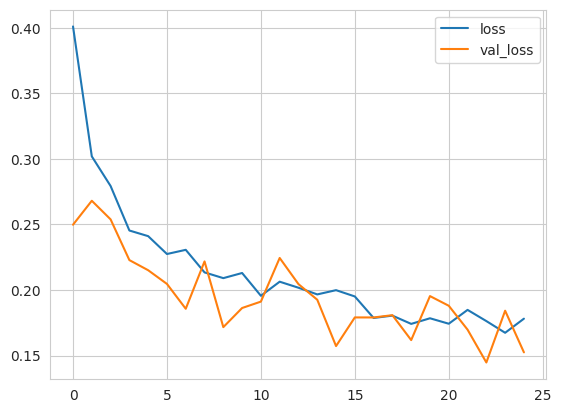

In [44]:
losses = pd.DataFrame(model_pretrained.history.history)
losses[['loss','val_loss']].plot()

<Axes: >

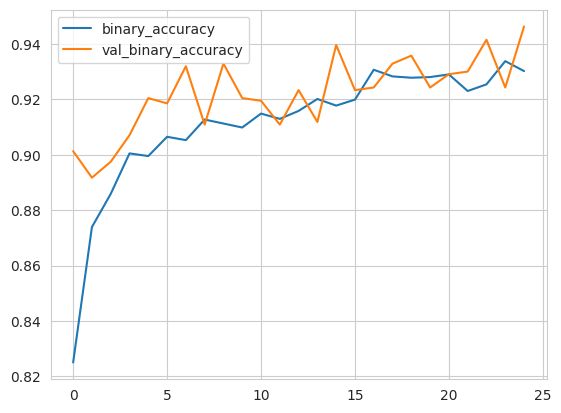

In [45]:
losses[['binary_accuracy','val_binary_accuracy']].plot()

In [46]:
print("Loss of the model is - " , model_pretrained.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model_pretrained.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 1s 69ms/step - loss: 0.2783 - binary_accuracy: 0.9054
Loss of the model is -  0.2783176004886627
20/20 [==============================] - 1s 70ms/step - loss: 0.2783 - binary_accuracy: 0.9054
Accuracy of the model is -  90.54487347602844 %


In [47]:
predictions = model_pretrained.predict(x_test)
pred_labels= np.where(predictions>0.5, 1, 0)


20/20 [==============================] - 4s 72ms/step


<Axes: >

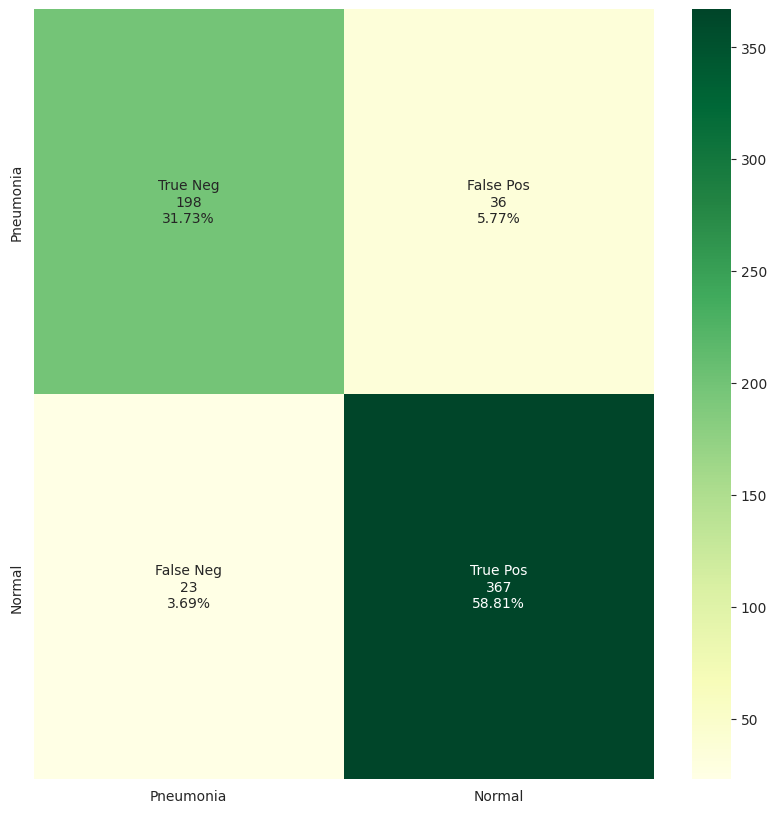

In [48]:
cf_matrix = confusion_matrix(y_test, pred_labels)
plt.figure(figsize = (10,10))

labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn",
           xticklabels = classes,yticklabels = classes)

In [49]:
cf_matrix

array([[198,  36],
       [ 23, 367]])

### Fine-tuning models

Notice that when we used pre-trained models, we haven't changed the weights, or retrained any of the ResNet layers. Simply put, we have updated the input and output of the models, while keeping all layers of the pre-trained models frozen. Although this is useful, in some cases you need to train some of the layers (update the weights of the model), and this is what is called fine-tuning the models. Here, we are going to unfreeze some layers and retrain. Note also, that we often keep lower layers frozen, because these capture generic features that may be shared with most images.


In [50]:
#Fine tunning
base_model.trainable = True

# Retrain the last 10 layers (all lower layers will be kept frozen)
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [51]:
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = tf.keras.optimizers.Adam(learning_rate=0.000002), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 4, 4, 2048)        58331648  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [52]:
history_ft = model_pretrained.fit(datagen.flow(x_train,y_train, batch_size = batch_size) ,
                    epochs = n_epochs , validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction],
                    steps_per_epoch = x_train.shape[0]/batch_size,
                    class_weight = class_weight
                   )

Epoch 1/25
261/260 [==============================] - ETA: 0s - loss: 0.4061 - binary_accuracy: 0.8830

260/260 [==============================] - 39s 107ms/step - loss: 0.4061 - binary_accuracy: 0.8830 - val_loss: 0.2236 - val_binary_accuracy: 0.9167 - lr: 2.0000e-06
Epoch 2/25
261/260 [==============================] - ETA: 0s - loss: 0.2818 - binary_accuracy: 0.9159

260/260 [==============================] - 25s 95ms/step - loss: 0.2818 - binary_accuracy: 0.9159 - val_loss: 0.2121 - val_binary_accuracy: 0.9195 - lr: 2.0000e-06
Epoch 3/25
261/260 [==============================] - ETA: 0s - loss: 0.2530 - binary_accuracy: 0.9142

260/260 [==============================] - 25s 95ms/step - loss: 0.2530 - binary_accuracy: 0.9142 - val_loss: 0.2259 - val_binary_accuracy: 0.9205 - lr: 2.0000e-06
Epoch 4/25
261/260 [==============================] - ETA: 0s - loss: 0.2519 - binary_accuracy: 0.9120

260/260 [==============================] - 25s 95ms/step - loss: 0.2519 - binary_accuracy: 0.9120 - val_loss: 0.2254 - val_binary_accuracy: 0.9100 - lr: 2.0000e-06
Epoch 5/25
261/260 [==============================] - ETA: 0s - loss: 0.2411 - binary_accuracy: 0.9029

260/260 [==============================] - 25s 94ms/step - loss: 0.2411 - binary_accuracy: 0.9029 - val_loss: 0.2387 - val_binary_accuracy: 0.9052 - lr: 2.0000e-06
Epoch 6/25
261/260 [==============================] - ETA: 0s - loss: 0.2298 - binary_accuracy: 0.9113

260/260 [==============================] - 25s 95ms/step - loss: 0.2298 - binary_accuracy: 0.9113 - val_loss: 0.2276 - val_binary_accuracy: 0.9042 - lr: 2.0000e-06
Epoch 7/25
261/260 [==============================] - ETA: 0s - loss: 0.2303 - binary_accuracy: 0.9060

260/260 [==============================] - 24s 93ms/step - loss: 0.2303 - binary_accuracy: 0.9060 - val_loss: 0.2023 - val_binary_accuracy: 0.9291 - lr: 2.0000e-06
Epoch 8/25
261/260 [==============================] - ETA: 0s - loss: 0.2281 - binary_accuracy: 0.9142

260/260 [==============================] - 24s 93ms/step - loss: 0.2281 - binary_accuracy: 0.9142 - val_loss: 0.2058 - val_binary_accuracy: 0.9148 - lr: 2.0000e-06
Epoch 9/25
261/260 [==============================] - ETA: 0s - loss: 0.2285 - binary_accuracy: 0.9106

260/260 [==============================] - 25s 94ms/step - loss: 0.2285 - binary_accuracy: 0.9106 - val_loss: 0.2115 - val_binary_accuracy: 0.9215 - lr: 2.0000e-06
Epoch 10/25
261/260 [==============================] - ETA: 0s - loss: 0.2198 - binary_accuracy: 0.9094

260/260 [==============================] - 25s 94ms/step - loss: 0.2198 - binary_accuracy: 0.9094 - val_loss: 0.1881 - val_binary_accuracy: 0.9310 - lr: 2.0000e-06
Epoch 11/25
261/260 [==============================] - ETA: 0s - loss: 0.2049 - binary_accuracy: 0.9214

260/260 [==============================] - 25s 97ms/step - loss: 0.2049 - binary_accuracy: 0.9214 - val_loss: 0.2066 - val_binary_accuracy: 0.9167 - lr: 2.0000e-06
Epoch 12/25
261/260 [==============================] - ETA: 0s - loss: 0.2055 - binary_accuracy: 0.9197

260/260 [==============================] - 25s 95ms/step - loss: 0.2055 - binary_accuracy: 0.9197 - val_loss: 0.1905 - val_binary_accuracy: 0.9253 - lr: 2.0000e-06
Epoch 13/25
261/260 [==============================] - ETA: 0s - loss: 0.2123 - binary_accuracy: 0.9166

260/260 [==============================] - 25s 94ms/step - loss: 0.2123 - binary_accuracy: 0.9166 - val_loss: 0.2020 - val_binary_accuracy: 0.9262 - lr: 2.0000e-06
Epoch 14/25
261/260 [==============================] - ETA: 0s - loss: 0.2066 - binary_accuracy: 0.9149

260/260 [==============================] - 24s 94ms/step - loss: 0.2066 - binary_accuracy: 0.9149 - val_loss: 0.2055 - val_binary_accuracy: 0.9195 - lr: 2.0000e-06
Epoch 15/25
261/260 [==============================] - ETA: 0s - loss: 0.2067 - binary_accuracy: 0.9171

260/260 [==============================] - 25s 96ms/step - loss: 0.2067 - binary_accuracy: 0.9171 - val_loss: 0.2017 - val_binary_accuracy: 0.9253 - lr: 2.0000e-06
Epoch 16/25
261/260 [==============================] - ETA: 0s - loss: 0.2115 - binary_accuracy: 0.9154

260/260 [==============================] - 25s 96ms/step - loss: 0.2115 - binary_accuracy: 0.9154 - val_loss: 0.1650 - val_binary_accuracy: 0.9387 - lr: 2.0000e-06
Epoch 17/25
261/260 [==============================] - ETA: 0s - loss: 0.2067 - binary_accuracy: 0.9154

260/260 [==============================] - 25s 96ms/step - loss: 0.2067 - binary_accuracy: 0.9154 - val_loss: 0.1852 - val_binary_accuracy: 0.9195 - lr: 2.0000e-06
Epoch 18/25
261/260 [==============================] - ETA: 0s - loss: 0.2005 - binary_accuracy: 0.9195

260/260 [==============================] - 25s 95ms/step - loss: 0.2005 - binary_accuracy: 0.9195 - val_loss: 0.1982 - val_binary_accuracy: 0.9243 - lr: 2.0000e-06
Epoch 19/25
261/260 [==============================] - ETA: 0s - loss: 0.1949 - binary_accuracy: 0.9228

260/260 [==============================] - 25s 96ms/step - loss: 0.1949 - binary_accuracy: 0.9228 - val_loss: 0.1932 - val_binary_accuracy: 0.9253 - lr: 2.0000e-06
Epoch 20/25
261/260 [==============================] - ETA: 0s - loss: 0.1929 - binary_accuracy: 0.9283

260/260 [==============================] - 25s 95ms/step - loss: 0.1929 - binary_accuracy: 0.9283 - val_loss: 0.1939 - val_binary_accuracy: 0.9310 - lr: 2.0000e-06
Epoch 21/25
261/260 [==============================] - ETA: 0s - loss: 0.2081 - binary_accuracy: 0.9161

260/260 [==============================] - 25s 96ms/step - loss: 0.2081 - binary_accuracy: 0.9161 - val_loss: 0.2015 - val_binary_accuracy: 0.9253 - lr: 2.0000e-06
Epoch 22/25
261/260 [==============================] - ETA: 0s - loss: 0.1863 - binary_accuracy: 0.9250

260/260 [==============================] - 25s 96ms/step - loss: 0.1863 - binary_accuracy: 0.9250 - val_loss: 0.1797 - val_binary_accuracy: 0.9339 - lr: 2.0000e-06
Epoch 23/25
261/260 [==============================] - ETA: 0s - loss: 0.1925 - binary_accuracy: 0.9214

260/260 [==============================] - 25s 96ms/step - loss: 0.1925 - binary_accuracy: 0.9214 - val_loss: 0.1900 - val_binary_accuracy: 0.9195 - lr: 2.0000e-06
Epoch 24/25
261/260 [==============================] - ETA: 0s - loss: 0.1944 - binary_accuracy: 0.9219

260/260 [==============================] - 25s 95ms/step - loss: 0.1944 - binary_accuracy: 0.9219 - val_loss: 0.2104 - val_binary_accuracy: 0.9234 - lr: 2.0000e-06
Epoch 25/25
261/260 [==============================] - ETA: 0s - loss: 0.1863 - binary_accuracy: 0.9271

260/260 [==============================] - 25s 95ms/step - loss: 0.1863 - binary_accuracy: 0.9271 - val_loss: 0.1946 - val_binary_accuracy: 0.9215 - lr: 2.0000e-06


* Evaluate your model by extracting metrics, store them in a pandas dataframe and reshape it for visualising results


In [53]:
print("Loss of the model is - " , model_pretrained.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model_pretrained.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 2s 73ms/step - loss: 0.2695 - binary_accuracy: 0.8878
Loss of the model is -  0.2695172131061554
20/20 [==============================] - 2s 73ms/step - loss: 0.2695 - binary_accuracy: 0.8878
Accuracy of the model is -  88.78205418586731 %


In [54]:
predictions = model_pretrained.predict(x_test)
pred_labels= np.where(predictions>0.5, 1, 0)

20/20 [==============================] - 4s 70ms/step


<Axes: >

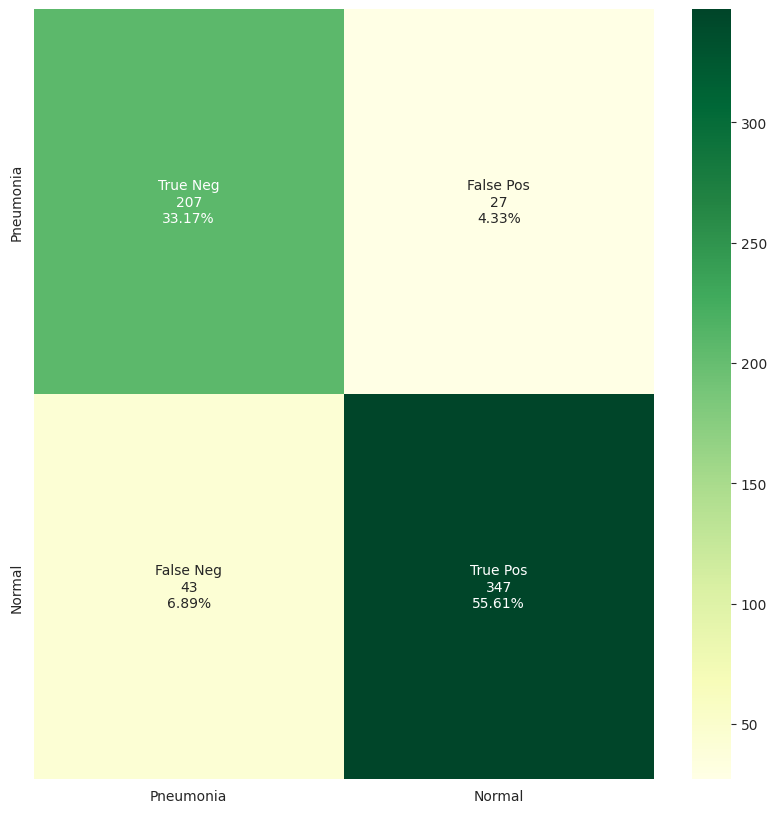

In [55]:
cf_matrix = confusion_matrix(y_test, pred_labels)
plt.figure(figsize = (10,10))

labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn",
           xticklabels = classes,yticklabels = classes)

## 5. Clean Up

Run the following cell to terminate the kernel and free memory before running new experiments:

In [56]:
#import os, signal
#os.kill(os.getpid(), signal.SIGKILL)